In [1]:
import matplotlib.pyplot as plt
import numpy as np

from abc import abstractmethod
from itertools import accumulate
import random
from typing import Protocol

In [2]:
class KArmedBandit(Protocol):
    @abstractmethod
    def arms(self) -> list[str]:
        raise NotImplementedError

    @abstractmethod
    def reward(self, arm: str) -> float:
        raise NotImplementedError


class BanditLearner(Protocol):
    name: str
    color: str

    @abstractmethod
    def reset(self, arms: list[str], time_steps: int):
        raise NotImplementedError

    @abstractmethod
    def pick_arm(self) -> str:
        raise NotImplementedError

    @abstractmethod
    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [3]:
class BanditProblem:
    def __init__(self, time_steps: int, bandit: KArmedBandit, learner: BanditLearner):
        self.time_steps: int = time_steps
        self.bandit: KArmedBandit = bandit
        self.learner: BanditLearner = learner
        self.learner.reset(self.bandit.arms(), self.time_steps)

    def run(self) -> list[float]:
        rewards = []
        for _ in range(self.time_steps):
            arm = self.learner.pick_arm()
            reward = self.bandit.reward(arm)
            self.learner.acknowledge_reward(arm, reward)
            rewards.append(reward)
        return rewards

In [235]:
def get_random_best_index(rewards):
    max_val = max(rewards)
    return random.choice([i for i, val in enumerate(rewards) if val == max_val])

In [50]:
POTENTIAL_HITS = {
    "April Showers": 0.5,
    "In Praise of Dreams": 0.8,
    "We Built This City": 0.9,
    "Twenty Four Hours": 0.3,
    "Dirge for November": 0.1,
}

In [5]:
class TopHitBandit(KArmedBandit):
    def __init__(self, potential_hits: dict[str, float]):
        self.potential_hits: dict[str, float] = potential_hits

    def arms(self) -> list[str]:
        return list(self.potential_hits)

    def reward(self, arm: str) -> float:
        thumb_up_probability = self.potential_hits[arm]
        return 1.0 if random.random() <= thumb_up_probability else 0.0

In [15]:
class RandomLearner(BanditLearner):
    def __init__(self):
        self.name = "Random"
        self.color = "black"
        self.arms: list[str] = []

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms

    def pick_arm(self) -> str:
        return random.choice(self.arms)

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        pass

In [236]:
class ExploreThenCommitLearner(BanditLearner):
    def __init__(self, explore_time = 5):
        self.name = f"ExploreThenCommit m={explore_time}"
        self.color = "green"
        self.explore_time = explore_time
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.best_arm: str | None = None
        self.rewards: list[float] = []
        self.counter = 0

    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.best_arm = None
        self.rewards = [0 for _ in range(len(self.arms))]
        self.counter = 0

    def pick_arm(self) -> str:
        if self.counter < self.explore_time * len(self.arms):
            arm = self.arms[self.counter % len(self.arms)]
            return arm
        
        if self.best_arm is None:
            self.best_arm = self.arms[get_random_best_index(self.rewards)]
        
        return self.best_arm

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.counter += 1
        self.rewards[self.arms_indexes[arm]] += reward

In [237]:
class GreedyLearner(BanditLearner):
    def __init__(self, explore_probability = 0.1, arm_start_val = 0):
        self.name = f"GreedyLearner exp={explore_probability}, start_val={arm_start_val}"
        self.color = "red"
        self.explore_probability = explore_probability
        self.arm_start_val = arm_start_val
        
        # Resetable
        self.arms: list[str] = []
        self.arms_indexes: dict[str: int] = dict()
        self.rewards: list[float] = []
        self.counter = 0


    def reset(self, arms: list[str], time_steps: int):
        self.arms = arms
        self.arms_indexes = {arm: i for i, arm in enumerate(self.arms)}
        self.rewards = [self.arm_start_val for _ in range(len(self.arms))]
        self.counter = 0


    def pick_arm(self) -> str:
        if random.random() < self.explore_probability:
            return random.choice(self.arms)
        
        return self.arms[get_random_best_index(self.rewards)]
    

    def acknowledge_reward(self, arm: str, reward: float) -> None:
        self.counter += 1
        current_reward = self.rewards[self.arms_indexes[arm]]
        self.rewards[self.arms_indexes[arm]] += (reward - current_reward) / self.counter

In [120]:
def evaluate_learner(learner: BanditLearner) -> None:
    runs_results = []
    for _ in range(TRIALS_PER_LEARNER):
        bandit = TopHitBandit(POTENTIAL_HITS)
        problem = BanditProblem(time_steps=TIME_STEPS, bandit=bandit, learner=learner)
        rewards = problem.run()
        accumulated_rewards = list(accumulate(rewards))
        runs_results.append(accumulated_rewards)

    runs_results = np.array(runs_results)
    mean_accumulated_rewards = np.mean(runs_results, axis=0)
    std_accumulated_rewards = np.std(runs_results, axis=0)
    plt.plot(mean_accumulated_rewards, label=learner.name, color=learner.color)
    plt.fill_between(
        range(len(mean_accumulated_rewards)),
        mean_accumulated_rewards - std_accumulated_rewards,
        mean_accumulated_rewards + std_accumulated_rewards,
        color=learner.color,
        alpha=0.2,
    )

In [121]:
TIME_STEPS = 1000
TRIALS_PER_LEARNER = 50

In [296]:
learners = [
    RandomLearner(),
    ExploreThenCommitLearner(20),
    GreedyLearner(explore_probability=0, arm_start_val=1)
        ]

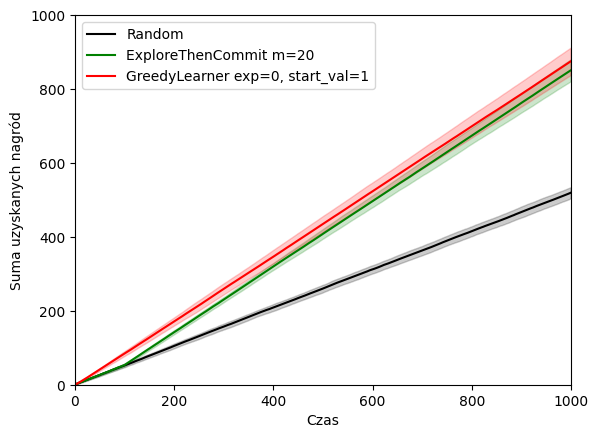

In [297]:
for learner in learners:
    evaluate_learner(learner)


plt.xlabel('Czas')
plt.ylabel('Suma uzyskanych nagród')
plt.xlim(0, TIME_STEPS)
plt.ylim(0, TIME_STEPS)
plt.legend()
plt.show()